In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# выгружаем данные из train.csv
data = pd.read_csv('train.csv')

In [3]:
data

,k,x
0,1,2.501035
1,2,3.257858
2,3,3.551333
3,4,3.513895
4,5,3.491913
...,...,...
95,96,8.969075
96,97,9.180991
97,98,9.042788
98,99,8.685214


Text(0, 0.5, 'x')

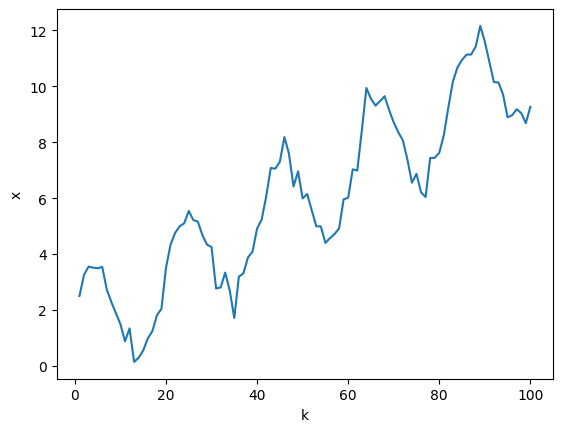

In [4]:
# визуализируем
x = data['x']
k = data['k']
plt.plot(k, x)
plt.xlabel('k')
plt.ylabel('x')

### Сначала найдем первое приближенное значение переменных a, omega, b, c.
### Они определяются с помощью быстрого преобразования Фурье (БПФ)

In [5]:
b, c = map(float, np.polyfit(k, x, 1)) # первое приближенное значение переменных b, c 

x_no_bias = x - np.polyval(np.polyfit(k, x, 1), k) # убираем смещение для анализа зашумленной синусоиды через БПФ

sample_len = len(x_no_bias)
sampling_step = k[1] - k[0]

freqs = np.fft.fftfreq(sample_len, sampling_step)
fft_res = np.fft.fft(x_no_bias)

# оставляем только первую половину результата БПФ, так как вторая половина соответсвует "отрицательным" частотам
# нулевой элемент не включаем, так как он соответсвует нулевой частоте
amplitudes = np.abs(fft_res)[1:sample_len//2] / (sample_len / 2)
freqs = freqs[1:100//2]

max_amp_ind = np.argmax(amplitudes) 

# первое приближенное значение переменных a и omega
a = amplitudes[max_amp_ind] 
omega = 2 * np.pi * freqs[max_amp_ind]

Text(0, 0.5, 'Amplitude')

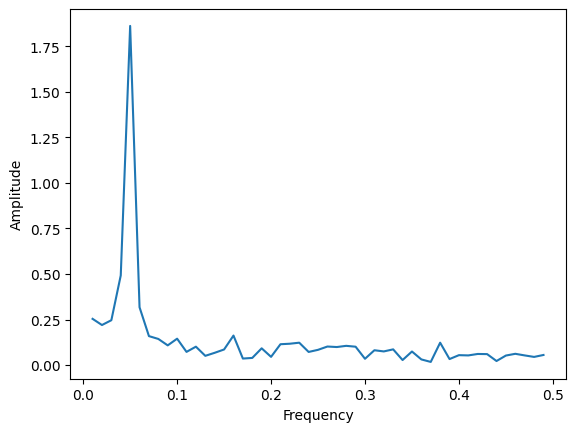

In [6]:
plt.plot(freqs, amplitudes)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

### Первое приближенное значение phi не задаю, так как оно плохо определяеяется из БПФ, из-за зашумления сигнала

In [7]:
initial_params = {'a': a, 'omega': omega, 'b': b, 'c': c}

In [8]:
np.random.seed(0)
torch.manual_seed(0)

### Создадим простую модель, которая будет выдавать значение $x = a \cdot \sin(\omega \cdot k + \phi) + b \cdot k + c$.
### Параметры модели $a, \omega, \phi, b, c$ будут настраиваться с помощью градиентного спуска и минимизируя функцию потерь MSE.

In [9]:
class SinusoidalModel(nn.Module):
    def __init__(self, init_params):
        super(SinusoidalModel, self).__init__()
        # Инициализация параметров a, omega, b, c берем из init_params
        self.a = nn.Parameter(torch.tensor(init_params['a']))
        self.omega = nn.Parameter(torch.tensor(init_params['omega']))
        self.phi = nn.Parameter(torch.randn(1))
        self.b = nn.Parameter(torch.tensor(init_params['b']))
        self.c = nn.Parameter(torch.tensor(init_params['c']))

    def forward(self, k):
        return self.a * torch.sin(self.omega * k + self.phi) + self.b * k + self.c

    def get_parameters(self): # возвращает параметры модели
        return {
            'a': self.a.item(),
            'omega': self.omega.item(),
            'phi': self.phi.item(),
            'b': self.b.item(),
            'c': self.c.item()
        }

In [10]:
model = SinusoidalModel(initial_params) 
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01) 

In [11]:
epochs = 1000 # количество эпох

# Переводим переменные k и x в тензоры 
k_tensor = torch.tensor(k) 
x_tensor = torch.tensor(x)


for epoch in range(epochs):
    optimizer.zero_grad()
    
    outputs = model(k_tensor) # модель считает выходные значения 
    loss = criterion(outputs, x_tensor) # считаем значение функции ошибки
    loss.backward() # вычисляем градиент функции потерь по параметрам a, omega, phi, b, c
    optimizer.step() # обновляем a, omega, phi, b, c

    # вывод на экран значение функции потерь
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f}')



Epoch 0, Loss: 4.499023
Epoch 100, Loss: 0.246461
Epoch 200, Loss: 0.118397
Epoch 300, Loss: 0.105808
Epoch 400, Loss: 0.105463
Epoch 500, Loss: 0.105460
Epoch 600, Loss: 0.105460
Epoch 700, Loss: 0.105460
Epoch 800, Loss: 0.105460
Epoch 900, Loss: 0.105460


### a_, omega_, phi_, b_, c_ - параметры после оптимизации

In [12]:
a_, omega_, phi_, b_, c_ = map(float, model.get_parameters().values())
print('Cкрытые параметры:')
print('a =', a_)
print('ω =', omega_)
print('φ =', phi_)
print('b =', b_)
print('c =', c_)

Cкрытые параметры:
a = 2.006995779128934
ω = 0.30091291334311265
φ = 0.4520013928413391
b = 0.09890130907297134
c = 1.0427465438842773


Визуализация, для сравнения исходных данных, первого приближения и оптимизированных параметров

Text(0, 0.5, 'x')

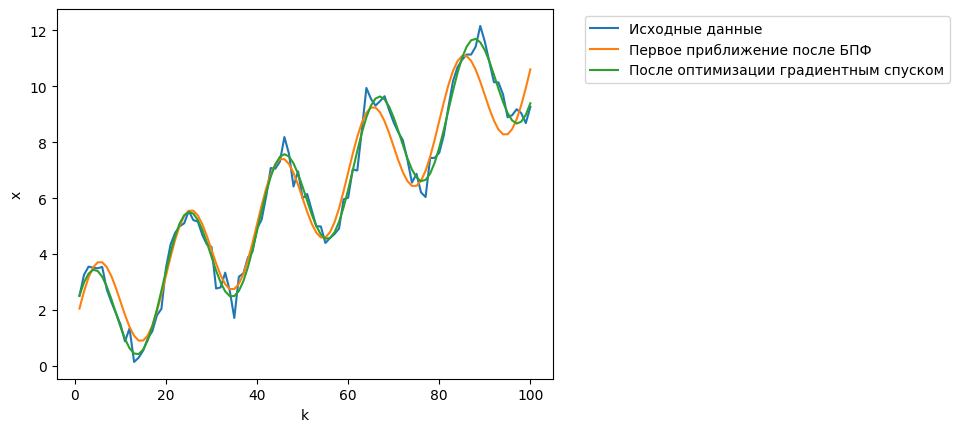

In [13]:
plt.plot(k, x, label='Исходные данные')
plt.plot(k,a * np.sin(omega * k) + b * k + c, label='Первое приближение после БПФ')
plt.plot(k,a_ * np.sin(omega_ * k + phi_) + b_ * k + c_, label='После оптимизации градиентным спуском')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('k')
plt.ylabel('x')

### Предсказание новых x по новым k

In [14]:
# Считываем новые значения k из файла test.csv
test_data = pd.read_csv('test.csv')
test_data.head()

,k
0,101
1,102
2,103
3,104
4,105


In [15]:
# рассчитываем новые значения x
k_pred = test_data['k']

x_pred = a_ * np.sin(omega_ * k_pred + phi_) + b_ * k_pred + c_

In [16]:
# создаем датафрейм для файла pred.csv
pred_data = pd.DataFrame()
pred_data['k'] = test_data['k']
pred_data['x'] = x_pred

#Записываем в файл
pred_data.to_csv('pred.csv', index=False)

pred_data

,k,x
0,101,9.945833
1,102,10.593789
2,103,11.289993
3,104,11.980768
4,105,12.612924
5,106,13.138539
6,107,13.519264
7,108,13.729774
8,109,13.760038
9,110,13.616225
